The goal of this notebook is to:

1. Illustrate how to plot vector and raster data with python GIS tools
2. Aggregate raster stats (with the aptly named `rasterstats` package) within polygonal areas.

We will investigate the mean backscatter and RGB within polygons of land areas that were drawn using shape files across some of our rasters.

In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from rasterstats import zonal_stats
from rasterio.plot import show
import geopandas as gpd
import pandas as pd

# Data Paths

In [2]:
data_path_name = 'data/tif_datacube/'
data_path = Path(data_path_name)
data_path.exists()

True

In [3]:
tif_paths = sorted(list(data_path.glob('*.tif')))
tif_paths

[PosixPath('data/tif_datacube/ALOS_RTC_2009_06_30_HH.tif'),
 PosixPath('data/tif_datacube/ALOS_RTC_2009_06_30_HV.tif'),
 PosixPath('data/tif_datacube/Hansen_GFC2015_last_10N_000E.tif'),
 PosixPath('data/tif_datacube/Hansen_GFC2015_treecover2000_10N_000E.tif')]

# Reading the Label Data

Each polygon represents a different land cover class.

In [4]:
label_data_path_name = 'data/labeled_data'
label_data_df = gpd.read_file(label_data_path_name)
label_data_df.head()

,class_id,class_name,geometry
0,0,forest,"POLYGON ((551360.6065915036 10060340.66369013,..."
1,1,water,"POLYGON ((555959.6271165322 10065712.31966336,..."
2,0,forest,"POLYGON ((558005.356285607 10057986.22742318, ..."
3,1,water,"POLYGON ((559270.2815323016 10063734.63547241,..."
4,2,mangroves,"POLYGON ((554620.5544992845 10062731.12009447,..."


# Plotting

Using `rasterio`, we plot the an HH backscatter image with our labeled data.

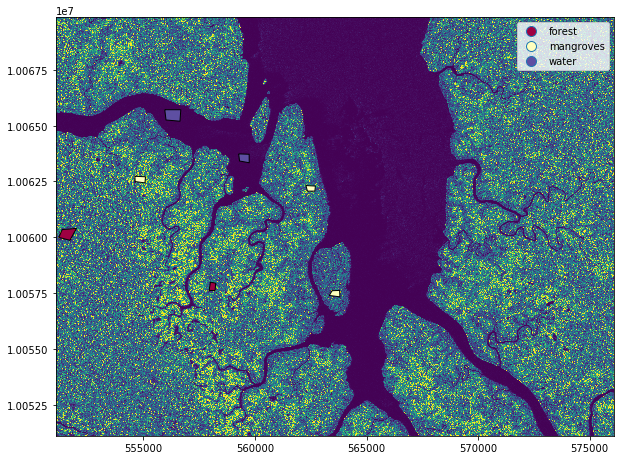

In [5]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(tif_paths[0]) as ds:
    show(ds, vmin=0, vmax=.5, ax=ax)
    label_data_df.plot(ax=ax, column='class_name', edgecolor='black', legend=True, cmap='Spectral')

# Computing th mean of backscatter and RGB within polygons

We use [`rasterstats`](https://pythonhosted.org/rasterstats/) for aggregating data across these polygons. For this tutorial, we only use the mean, though the standard deviation, max, min, count, and even custom functions.

In [6]:
zonal_stats_hh = zonal_stats(label_data_df, tif_paths[0], stats='mean')
zonal_stats_hh

[{'mean': 0.2167930006263632},
 {'mean': 0.003346100930244692},
 {'mean': 0.1892786311935075},
 {'mean': 0.006217618465423584},
 {'mean': 0.2759928371817033},
 {'mean': 0.2407266230062554},
 {'mean': 0.16261585565546757}]

Observe that we have the same number of values ans polygons.

In [7]:
len(zonal_stats_hh), label_data_df.shape[0]

(7, 7)

We are going to rename the key from `mean` to `mean_hh` so that we can format this data into our dataframe.

In [8]:
zonal_stats_hh = [{'mean_hh': data['mean']} for data in zonal_stats_hh]
zonal_stats_hh

[{'mean_hh': 0.2167930006263632},
 {'mean_hh': 0.003346100930244692},
 {'mean_hh': 0.1892786311935075},
 {'mean_hh': 0.006217618465423584},
 {'mean_hh': 0.2759928371817033},
 {'mean_hh': 0.2407266230062554},
 {'mean_hh': 0.16261585565546757}]

Let's compute the mean across the other rasters.

In [9]:
zonal_stats_hv = zonal_stats(label_data_df, tif_paths[1], stats='mean')
zonal_stats_hv = [{'mean_hv': data['mean']} for data in zonal_stats_hv]
zonal_stats_hv

[{'mean_hv': 0.06695165071820237},
 {'mean_hv': 0.001444972896033039},
 {'mean_hv': 0.06398950136107322},
 {'mean_hv': 0.0013621718883514405},
 {'mean_hv': 0.05154468923966515},
 {'mean_hv': 0.05542115487506939},
 {'mean_hv': 0.047067083610569396}]

We now show how we aggregate the bands of the Hansen mosaics. There are 4 bands (red, green, blue, red edge). We only look at red and this is why we use `band=1`.

In [10]:
zonal_stats_red = zonal_stats(label_data_df, tif_paths[2], stats='mean', band=1)
zonal_stats_red = [{'mean_red': data['mean']} for data in zonal_stats_red]
zonal_stats_red

/Users/cmarshak/anaconda3/lib/python3.7/site-packages/rasterstats/io.py:301: UserWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn("Setting nodata to -999; specify nodata explicitly")


[{'mean_red': 13.998194945848375},
 {'mean_red': 0.21537001897533206},
 {'mean_red': 9.75485008818342},
 {'mean_red': 0.628},
 {'mean_red': 15.774064171122994},
 {'mean_red': 15.10051993067591},
 {'mean_red': 14.638846737481032}]

# Appending the statistics to the vector data

In [11]:
analysis_df = pd.concat([label_data_df,
                         pd.DataFrame(zonal_stats_hh),
                         pd.DataFrame(zonal_stats_hv),
                         pd.DataFrame(zonal_stats_red)], axis=1)
analysis_df.head()

,class_id,class_name,geometry,mean_hh,mean_hv,mean_red
0,0,forest,"POLYGON ((551360.6065915036 10060340.66369013,...",0.216793,0.066952,13.998195
1,1,water,"POLYGON ((555959.6271165322 10065712.31966336,...",0.003346,0.001445,0.215370
2,0,forest,"POLYGON ((558005.356285607 10057986.22742318, ...",0.189279,0.063990,9.754850
3,1,water,"POLYGON ((559270.2815323016 10063734.63547241,...",0.006218,0.001362,0.628000
4,2,mangroves,"POLYGON ((554620.5544992845 10062731.12009447,...",0.275993,0.051545,15.774064


In [12]:
analysis_df['mean_hh_db'] = analysis_df['mean_hh'].map(lambda val: 10 * np.log10(val))
analysis_df['mean_hv_db'] = analysis_df['mean_hv'].map(lambda val: 10 * np.log10(val))
analysis_df

,class_id,class_name,geometry,mean_hh,mean_hv,mean_red,mean_hh_db,mean_hv_db
0,0,forest,"POLYGON ((551360.6065915036 10060340.66369013,...",0.216793,0.066952,13.998195,-6.639547,-11.742387
1,1,water,"POLYGON ((555959.6271165322 10065712.31966336,...",0.003346,0.001445,0.215370,-24.754610,-28.401403
2,0,forest,"POLYGON ((558005.356285607 10057986.22742318, ...",0.189279,0.063990,9.754850,-7.228984,-11.938913
3,1,water,"POLYGON ((559270.2815323016 10063734.63547241,...",0.006218,0.001362,0.628000,-22.063759,-28.657681
4,2,mangroves,"POLYGON ((554620.5544992845 10062731.12009447,...",0.275993,0.051545,15.774064,-5.591022,-12.878161
5,2,mangroves,"POLYGON ((562280.6568247549 10062315.4556272, ...",0.240727,0.055421,15.100520,-6.184759,-12.563244
6,2,mangroves,"POLYGON ((563455.7503008131 10057603.86383635,...",0.162616,0.047067,14.638847,-7.888371,-13.272827


Let's plot the mean of the HH backscatter within a polygon.

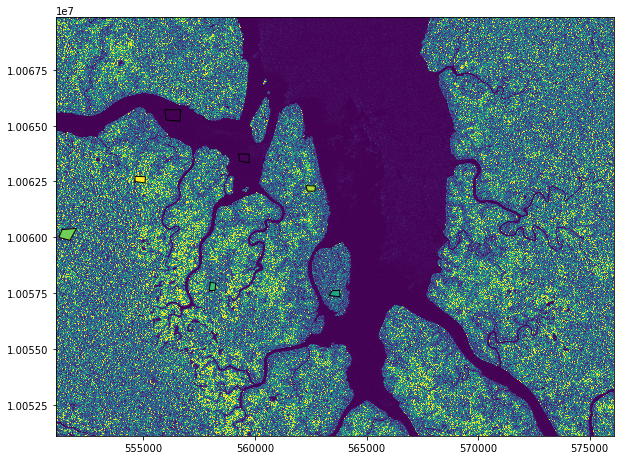

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))
with rasterio.open(tif_paths[0]) as ds:
    show(ds, vmin=0, vmax=.5, ax=ax)
    analysis_df.plot(ax=ax, column='mean_hh', edgecolor='black', cmap='viridis')